Developing code to calculate $\alpha_{\rm beam}$ and the corresponding amplitude $A_{\rm beam}$

In [67]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c

from scipy.interpolate import interp2d

aspect_ratio = 16./9
BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'

In [25]:
CTL_stellar_radius_model = np.genfromtxt("Stassun2018_Table4.txt", usecols=(1,2), names=('Teff', 'Radius'))
CTL_stellar_mass_model = np.genfromtxt("Stassun2018_Table5.txt", usecols=(1,2), names=('Teff', 'Mass'))

def interp_Teff(Mstar, model=CTL_stellar_mass_model):
    log_Teffs = np.log10(model['Teff'][::-1])
    log_Mstars = np.log10(model['Mass'][::-1])
       
    return 10.**(np.interp(np.log10(Mstar), log_Mstars, log_Teffs))

def interp_Rstar(Mstar, radius_model=CTL_stellar_radius_model, mass_model=CTL_stellar_mass_model):
    
    Mstars = mass_model['Mass'][::-1]
    Radii = radius_model['Radius'][::-1]
    
    return np.interp(Mstar, Mstars, Radii)

def calc_logg(Mstar):
    units_Mstar = Mstar*u.Msun
    units_Rstar = interp_Rstar(Mstar)*u.Rsun
    
    return np.log10((c.G*units_Mstar/units_Rstar**2).to('cm/s^2').value)

2.1
12435.3792135
4.094659033499276


(0, 4)

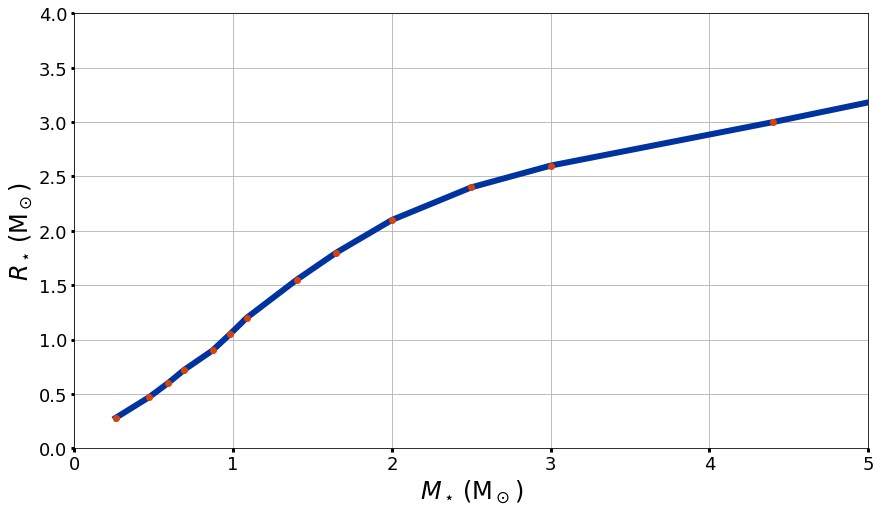

In [5]:
print(interp_Rstar(2.))
print(calc_logg(2.))

fig = plt.figure(figsize=(8*aspect_ratio,8))
ax = fig.add_subplot(111)
    
# ax.plot(CTL_stellar_mass_model['Mass'], CTL_stellar_mass_model['Teff'], lw=6, 
#         color=BoiseState_blue, marker='o', ls='')
# ax.plot(CTL_stellar_radius_model['Radius'], CTL_stellar_mass_model['Teff'], lw=6, 
#         color=BoiseState_orange, marker='o', ls='')

ax.plot(CTL_stellar_mass_model['Mass'], CTL_stellar_radius_model['Radius'], lw=6, 
        color=BoiseState_blue)

ax.plot(CTL_stellar_mass_model['Mass'], interp_Rstar(CTL_stellar_mass_model['Mass']), lw=6, 
        color=BoiseState_orange, marker='o', ls='')

ax.set_ylabel('$R_\star\, {\\rm (M_\\odot)}$', fontsize=24)
ax.set_xlabel('$M_\star\, {\\rm (M_\\odot)}$', fontsize=24)
ax.tick_params(which='both', labelsize=18)
ax.grid(True)

ax.set_xlim([0, 5])
ax.set_ylim([0, 4])

In [6]:
# From Shporer (2017)
def alpha_beam_nu(nu, Teff):
    """Calculates frequency-specific beaming coefficient, assuming blackbody radiation -
        see `Sphorer (2017) <http://adsabs.harvard.edu/abs/2017PASP..129g2001S>`_, Eqn 6
    
    Args:
        nu (float or numpy array): frequency/frequencies at which to evaluate beaming coefficient.
        Teff (float): stellar effective temperature.
        
    Returns:
        float: frequency-specific beaming coefficient (unitless)
    """
    
    nu = np.asarray(nu)
    
    x = (c.h*nu/(c.k_B*Teff)).value
    
    return 1./4*(x*np.exp(x))/(np.exp(x) - 1.)

def alpha_beam(Teff, resp_func):
    """Calculates band-integrated beaming coefficient, assuming blackbody radiation

    2019 Feb 13 - 
    `Kepler mission response function` <https://keplerscience.arc.nasa.gov/the-kepler-space-telescope.html>`_ 
    `TESS mission response function` <https://heasarc.gsfc.nasa.gov/docs/tess/the-tess-space-telescope.html>`_

    Args:
        Teff (float): stellar effective temperature.
        resp_func (dict):   resp_func['wavelength'] are the response function wavelengths, 
                            resp_func['resp'] are the response function values per wavelength bin.
        
    Returns:
        float: band-integrated beaming coefficient
    """
    
    # Convert wavelength to frequency
    nus = (c.c/resp_func['wavelength']).to('Hz')
    
    # Normalize response function
    norm = np.trapz(resp_func['resp'])
    resp_func['resp'] /= norm
    resp_func['resp'] = resp_func['resp']/u.nm

    # Convert response function - df/d(nu) = df/d(lambda) d(lambda)/d(nu)
    dfdnu = (resp_func['resp'].to('1/m')*c.c/(nus*nus)).to('1/Hz')
    func = (alpha_beam_nu(nus, Teff)*dfdnu)

    return np.trapz(func[::-1], nus[::-1])/np.trapz(dfdnu[::-1], nus[::-1])

In [7]:
Teff = 6000.*u.K

data = np.genfromtxt('kepler_response_hires1.txt', names=('wavelength', 'resp'))
Kepler_resp_func = {'wavelength': data['wavelength']*u.nanometer, 'resp': data['resp']}
print("Kepler: ", alpha_beam(Teff, Kepler_resp_func))

data = np.genfromtxt('tess-response-function-v1.0.csv', delimiter=',', names=('wavelength', 'resp'))
TESS_resp_func = {'wavelength': data['wavelength']*u.nanometer, 'resp': data['resp']}
print("TESS: ", alpha_beam(Teff, TESS_resp_func))

('Kepler: ', <Quantity 0.99167436>)
('TESS: ', <Quantity 0.80839399>)


In [8]:
# Range taken from here - https://filtergraph.com/tess_ctl

Teffs = np.linspace(3000., 8000., 501)
Kepler_alpha_beams = np.zeros_like(Teffs)
TESS_alpha_beams = np.zeros_like(Teffs)

for i in range(len(Teffs)):
    Kepler_alpha_beams[i] = alpha_beam(Teffs[i], Kepler_resp_func)
    TESS_alpha_beams[i] = alpha_beam(Teffs[i], TESS_resp_func)

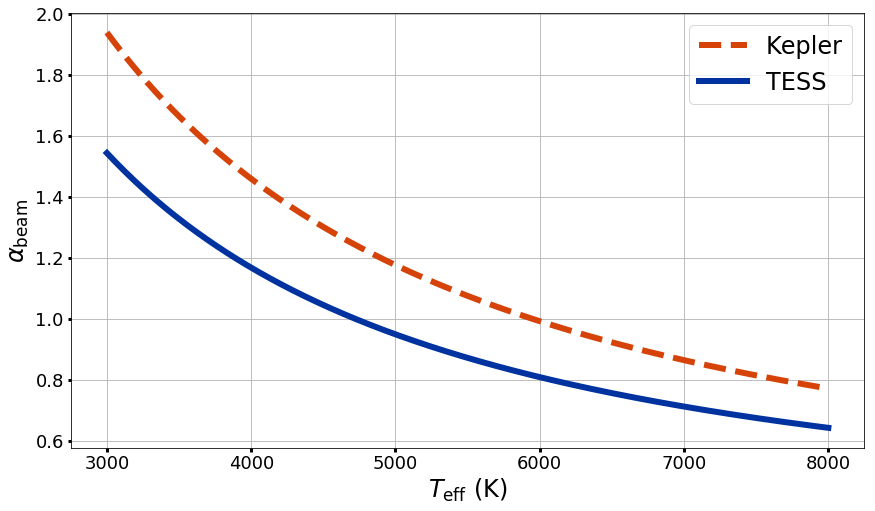

In [9]:
fig = plt.figure(figsize=(8*aspect_ratio,8))
ax = fig.add_subplot(111)
    
ax.plot(Teffs, Kepler_alpha_beams, lw=6, color=BoiseState_orange, ls='--', label='Kepler')
ax.plot(Teffs, TESS_alpha_beams, lw=6, color=BoiseState_blue, label='TESS')
ax.set_xlabel('$T_{\\rm eff}$ (K)', fontsize=24)
ax.set_ylabel('$\\alpha_{\\rm beam}$', fontsize=24)
ax.tick_params(which='both', labelsize=18)
ax.grid(True)
ax.legend(loc='best', fontsize=24)

In [10]:
def Abeam(Mstar, period, Mp_sini, resp=TESS_resp_func):
    
    cur_Teff = interp_Teff(Mstar)
    cur_alpha_beam = alpha_beam(cur_Teff, resp)
    
    # Eqn 4 from Shporer (2017), in ppm
    return 2.7*cur_alpha_beam*(period)**(-1./3)*(Mstar)**(-2./3)*Mp_sini

(3251.2679412674447, 8180.000000000003)


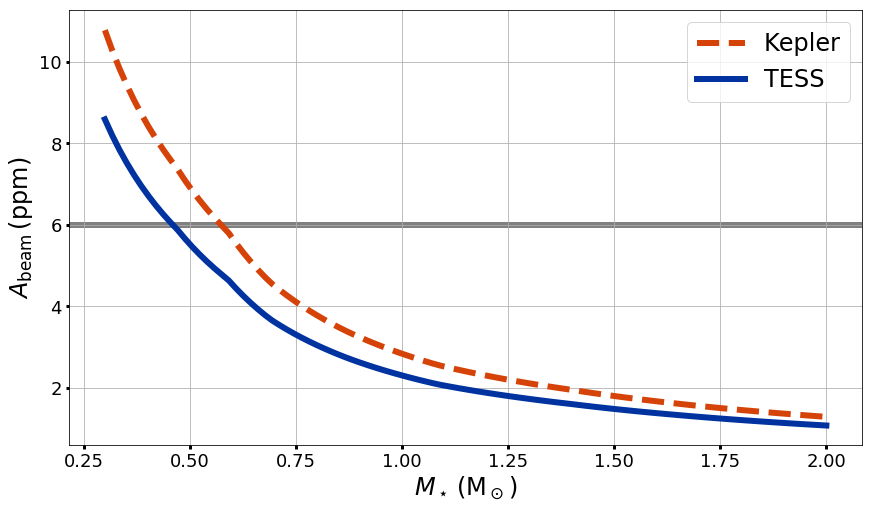

In [12]:
Mstars = np.linspace(0.3, 2., 100)
TESS_Abeams = np.zeros_like(Mstars)
Kepler_Abeams = np.zeros_like(Mstars)

Teffs = interp_Teff(Mstars)

print(np.min(Teffs), np.max(Teffs))

# WASP-18 parameters
# Mp_sini = 10.4*np.sin(84.31*np.pi/180.)
# period = 0.9414576

Mp_sini = 1.
period = 1.

for i in range(len(Mstars)):
    TESS_Abeams[i] = Abeam(Mstars[i], period, Mp_sini)
    Kepler_Abeams[i] = Abeam(Mstars[i], period, Mp_sini, resp=Kepler_resp_func)
    
fig = plt.figure(figsize=(8*aspect_ratio,8))
ax = fig.add_subplot(111)

ax.plot(Mstars, Kepler_Abeams, lw=6, color=BoiseState_orange, label="Kepler", ls='--')    
ax.plot(Mstars, TESS_Abeams, lw=6, color=BoiseState_blue, label="TESS")
ax.set_ylabel('$A_{\\rm beam}\,$(ppm)', fontsize=24)
ax.set_xlabel('$M_\star\, {\\rm (M_\\odot)}$', fontsize=24)
ax.tick_params(which='both', labelsize=18)
ax.grid(True)
ax.legend(loc='best', fontsize=24)

# The uncertainties on WASP-18 b's Abeam from Shprorer et al. (2018)
ax.axhline(6.0, color='grey', lw=6, zorder=-1)

10.348758049469094


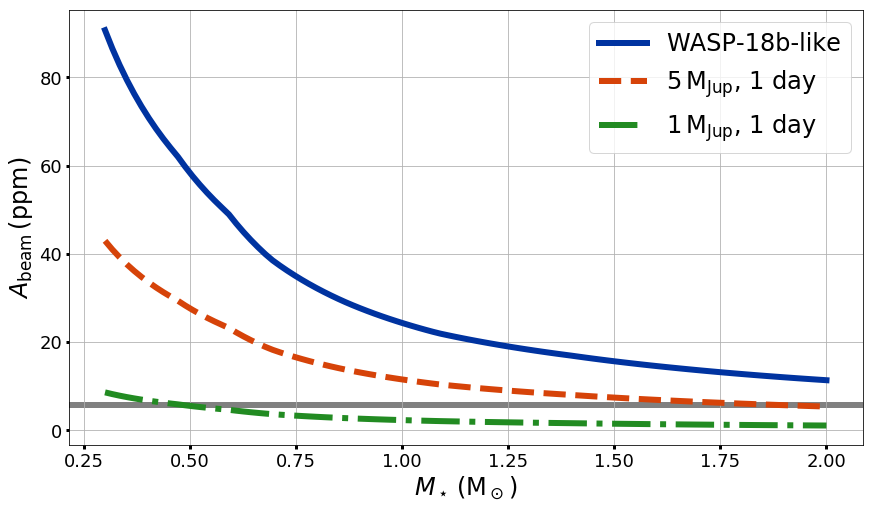

In [17]:
fig = plt.figure(figsize=(8*aspect_ratio,8))
ax = fig.add_subplot(111)

# WASP-18 parameters
Mp_sini = 10.4*np.sin(84.31*np.pi/180.)
print(Mp_sini)
period = 0.9414576

Mstars = np.linspace(0.3, 2., 100)
TESS_Abeams = np.zeros_like(Mstars)

for i in range(len(Mstars)):
    TESS_Abeams[i] = Abeam(Mstars[i], period, Mp_sini)
    
ax.plot(Mstars, TESS_Abeams, lw=6, color=BoiseState_blue, label="WASP-18b-like")

Mp_sini = 5.
period = 1.
TESS_Abeams = np.zeros_like(Mstars)

for i in range(len(Mstars)):
    TESS_Abeams[i] = Abeam(Mstars[i], period, Mp_sini)
    
ax.plot(Mstars, TESS_Abeams, lw=6, color=BoiseState_orange, ls='--', label="$5\, {\\rm M_{Jup}}$, 1 day")

Mp_sini = 1.
period = 1.
TESS_Abeams = np.zeros_like(Mstars)
for i in range(len(Mstars)):
    TESS_Abeams[i] = Abeam(Mstars[i], period, Mp_sini)
    
ax.plot(Mstars, TESS_Abeams, lw=6, color='forestgreen', ls='-.', label="$1\, {\\rm M_{Jup}}$, 1 day")

ax.set_ylabel('$A_{\\rm beam}\,$(ppm)', fontsize=24)
ax.set_xlabel('$M_\star\, {\\rm (M_\\odot)}$', fontsize=24)
ax.tick_params(which='both', labelsize=18)
ax.grid(True)
ax.legend(loc='best', fontsize=24)

# The uncertainties on WASP-18 b's Abeam from Shprorer et al. (2018)
ax.axhline(5.8, color='grey', lw=6, zorder=-1)

# fig.savefig("../alpha_beam_Abeam.png", dpi=500, bbox_inches='tight')

Next, let's look at $A_{\rm ellip}$.

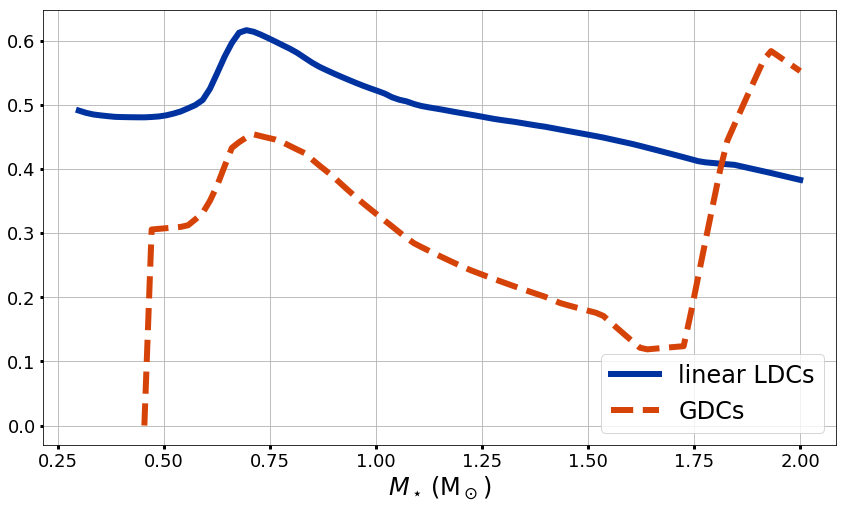

In [113]:
Claret_Table13 = np.genfromtxt('Claret2017_Table13.txt', 
                               usecols=(0, 1, 2, 4), names=("logg", "Teff", "Z", "linear_LDC"))
Claret_Table13_loggs = np.sort(np.unique(Claret_Table13["logg"]))
Claret_Table13_Teffs = np.sort(np.unique(Claret_Table13["Teff"]))
Claret_Table13_Zs = np.sort(np.unique(Claret_Table13["Z"]))

Claret_Table29 = np.genfromtxt('Claret2017_Table29.txt', 
                               usecols=(0, 2, 3, 4), names=("Z", "logg", "logTeff", "GDC"))
Claret_Table29_loggs = np.sort(np.unique(Claret_Table29["logg"]))
Claret_Table29_logTeffs = np.sort(np.unique(Claret_Table29["logTeff"]))
Claret_Table29_Zs = np.sort(np.unique(Claret_Table13["Z"]))

def calc_linear_LDC(Mstar):
    # Very simple version of LDC calculation using TIC stellar parameters and Claret (2017) data
    
    logg = calc_logg(Mstar)
    Teff = interp_Teff(Mstar)
    # Assume solar metallicity 'cause why not?
    Z = 0.
    
    # First find the right log(g)-values
    min_logg = Claret_Table13_loggs[Claret_Table13_loggs <= logg][-1]
    if(min_logg >= np.max(Claret_Table13_loggs)):
        raise ValueError("calc_linear_LDC: log(g) too large!")
    next_logg = Claret_Table13_loggs[Claret_Table13_loggs >= logg][0]
    
    min_Teff = Claret_Table13_Teffs[Claret_Table13_Teffs <= Teff][-1]
    if(min_Teff >= np.max(Claret_Table13_Teffs)):
        raise ValueError("calc_linear_LDC: Teff too large!")
    next_Teff = Claret_Table13_Teffs[Claret_Table13_Teffs >= Teff][0]
    
    ind0 = ((Claret_Table13["logg"] == min_logg) & (Claret_Table13["Teff"] == min_Teff))
    ind1 = ((Claret_Table13["logg"] == next_logg) & (Claret_Table13["Teff"] == min_Teff))
    ind2 = ((Claret_Table13["logg"] == min_logg) & (Claret_Table13["Teff"] == next_Teff))
    ind3 = ((Claret_Table13["logg"] == next_logg) & (Claret_Table13["Teff"] == next_Teff))
    
    x = np.array([min_logg, next_logg])
    y = np.array([min_Teff, next_Teff])
    z = np.array([[Claret_Table13["linear_LDC"][ind0][0], Claret_Table13["linear_LDC"][ind1][0]],
                  [Claret_Table13["linear_LDC"][ind2][0], Claret_Table13["linear_LDC"][ind3][0]]])
    
    new_LDC = interp2d(x, y, z)
    
    return new_LDC(logg, Teff)[0]
    
def calc_GDC(Mstar):
    # Very simple calculation of gravity-darkening coefficient

    logg = calc_logg(Mstar)
    logTeff = np.log10(interp_Teff(Mstar))
    # Assume solar metallicity 'cause why not?
    Z = 0.
    
    # First find the right log(g)-values
    min_logg = Claret_Table29_loggs[Claret_Table29_loggs <= logg][-1]
    if(min_logg >= np.max(Claret_Table29_loggs)):
        raise ValueError("calc_GDC: log(g) too large!")
    next_logg = Claret_Table29_loggs[Claret_Table29_loggs >= logg][0]
    
    if(logTeff < np.min(Claret_Table29_logTeffs)):
        min_logTeff = np.min(Claret_Table29_logTeffs)
    else:
        min_logTeff = Claret_Table29_logTeffs[Claret_Table29_logTeffs <= logTeff][-1]
    if(min_logTeff >= np.max(Claret_Table29_logTeffs)):
        raise ValueError("calc_GDC: Teff too large!")

    next_logTeff = Claret_Table29_logTeffs[Claret_Table29_logTeffs >= logTeff][0]
    
    ind0 = ((Claret_Table29["logg"] == min_logg) & (Claret_Table29["logTeff"] == min_logTeff))
    ind1 = ((Claret_Table29["logg"] == next_logg) & (Claret_Table29["logTeff"] == min_logTeff))
    ind2 = ((Claret_Table29["logg"] == min_logg) & (Claret_Table29["logTeff"] == next_logTeff))
    ind3 = ((Claret_Table29["logg"] == next_logg) & (Claret_Table29["logTeff"] == next_logTeff))
    
    x = np.array([min_logg, next_logg])
    y = np.array([min_logTeff, next_logTeff])
    z = np.array([[Claret_Table29["GDC"][ind0][0], Claret_Table29["GDC"][ind1][0]],
                  [Claret_Table29["GDC"][ind2][0], Claret_Table29["GDC"][ind3][0]]])
    
    new_GDC = interp2d(x, y, z)
    
    return new_GDC(logg, logTeff)[0]
    
# def alpha_ellip(Mstar):

Mstar = 1.
# print(calc_logg(Mstar), interp_Teff(Mstar), calc_linear_LDC(Mstar))
# print(calc_GDC(Mstar))

fig = plt.figure(figsize=(8*aspect_ratio,8))
ax = fig.add_subplot(111)

LDCs = np.zeros_like(Mstars)
GDCs = np.zeros_like(Mstars)
for i in range(len(Mstars)):
    LDCs[i] = calc_linear_LDC(Mstars[i])
    GDCs[i] = calc_GDC(Mstars[i])

ax.plot(Mstars, LDCs, lw=6, color=BoiseState_blue, label="linear LDCs")
ax.plot(Mstars, GDCs, lw=6, color=BoiseState_orange, ls='--', label="GDCs")

ax.set_xlabel('$M_\star\, {\\rm (M_\\odot)}$', fontsize=24)
ax.tick_params(which='both', labelsize=18)
ax.grid(True)
ax.legend(loc='best', fontsize=24)

In [124]:
def alpha_ellip(Mstar):
    # Very simple calculation of alpha_ellip parameter
    
    u = calc_linear_LDC(Mstar)
    g = calc_GDC(Mstar)
    
    ret_val = None
    
    if((np.isfinite(g) or ~np.isnan(g))):
        #Morris (1983) by way of Shporer (2017), Eqn 8
        ret_val = 0.15*(15. + u)*(1. + g)/(3. - u)
        
    return ret_val

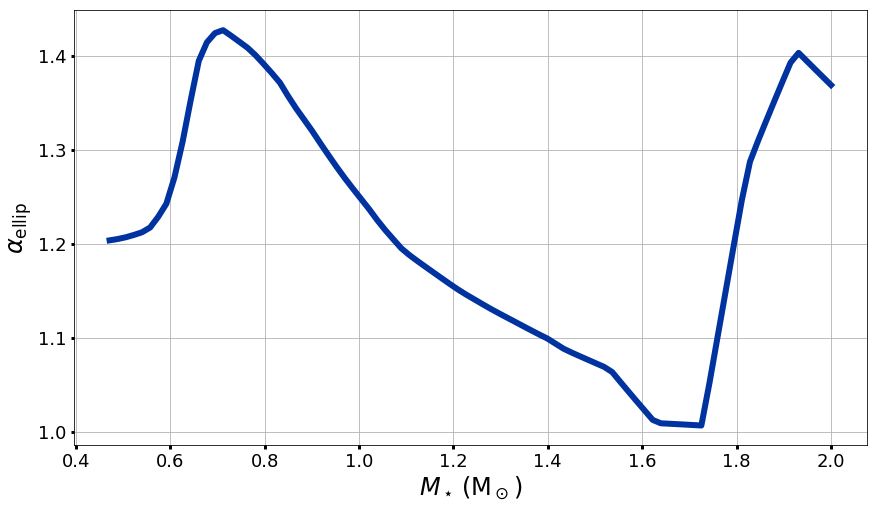

In [127]:
fig = plt.figure(figsize=(8*aspect_ratio,8))
ax = fig.add_subplot(111)

alpha_ellips = np.zeros_like(Mstars)
for i in range(len(Mstars)):
    alpha_ellips[i] = alpha_ellip(Mstars[i])

ax.plot(Mstars, alpha_ellips, lw=6, color=BoiseState_blue)

ax.set_ylabel('$\\alpha_{\\rm ellip}$', fontsize=24)
ax.set_xlabel('$M_\star\, {\\rm (M_\\odot)}$', fontsize=24)
ax.tick_params(which='both', labelsize=18)
ax.grid(True)

In [132]:
def Aellip(Mstar, period, Mp, sin_i):
    Rstar = interp_Rstar(Mstar)
    cur_alpha_ellip = alpha_ellip(Mstar)
    
    # Eqn 7 from Shporer (2017)
    return 13.*cur_alpha_ellip*sin_i*Rstar**3.*Mstar**(-2.)*period**(-2.)*Mp*sin_i

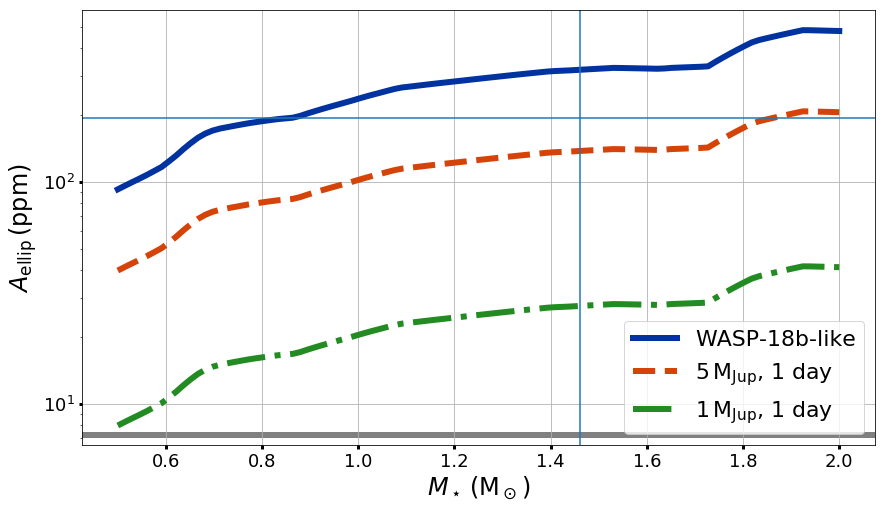

In [138]:
fig = plt.figure(figsize=(8*aspect_ratio,8))
ax = fig.add_subplot(111)

Mstars = np.linspace(0.5, 2., 100)

# WASP-18 parameters
Mp = 10.4
sin_i = np.sin(84.31*np.pi/180.)
period = 0.9414576
Aellips = np.zeros_like(Mstars)
for i in range(len(Mstars)):
    Aellips[i] = Aellip(Mstars[i], period, Mp, sin_i)
ax.semilogy(Mstars, Aellips, lw=6, color=BoiseState_blue, label="WASP-18b-like")

#############

Mp = 5.
period = 1.
sin_i = 1.
Aellips = np.zeros_like(Mstars)
for i in range(len(Mstars)):
    Aellips[i] = Aellip(Mstars[i], period, Mp, sin_i)
ax.semilogy(Mstars, Aellips, lw=6, color=BoiseState_orange, ls='--', label="$5\, {\\rm M_{Jup}}$, 1 day")

#############

Mp = 1.
period = 1.
sin_i = 1.
Aellips = np.zeros_like(Mstars)
for i in range(len(Mstars)):
    Aellips[i] = Aellip(Mstars[i], period, Mp, sin_i)
ax.semilogy(Mstars, Aellips, lw=6, color='forestgreen', ls='-.', label="$1\, {\\rm M_{Jup}}$, 1 day")

#############

ax.set_ylabel('$A_{\\rm ellip}\,$(ppm)', fontsize=24)
ax.set_xlabel('$M_\star\, {\\rm (M_\\odot)}$', fontsize=24)
ax.tick_params(which='both', labelsize=18)
ax.grid(True)
ax.legend(loc='best', fontsize=22)

# The uncertainties on WASP-18 b's Abeam from Shprorer et al. (2018)
ax.axhline(7.2, color='grey', lw=6, zorder=-1)
ax.axvline(1.46)
ax.axhline(194.2)

# fig.savefig("../alpha_beam_Abeam.png", dpi=500, bbox_inches='tight')